In [1]:
import os
import ray
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark

Last updated: 2024-02-26T19:37:21.995268-08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.18.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit



In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-02-26 19:37:24,684	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'memory': 17064697038.0,
 'CPU': 28.0,
 'node:__internal_head__': 1.0,
 'node:172.30.66.101': 1.0,
 'object_store_memory': 8532348518.0,
 'GPU': 1.0,
 'accelerator_type:G': 1.0}

In [5]:
num_workers = 1
num_devices = 1
resources_per_worker = {"CPU": 8, "GPU": 1}

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.rcParams["figure.dpi"] = 300
sns.set_theme(style="whitegrid")

## 🍲 Data

In [7]:
data_path = Path("../data/cafa5")

In [8]:
df = pd.read_parquet(data_path / "top100_train_split.parquet")
print(df.shape)
df.head()

(42074, 3)


,Entry ID,Sequence,Index
27571,Q15077,MEWDNGTGQALGLPPTTCVYRENFKQLLLPPVYSAVLAAGLPLNIC...,27571
38831,Q8L500,MGEIVVLSSDDGMETIKNRVKSSEVVQWEKYLPKTVLRVLLVESDY...,38831
22298,P53961,MISKEYEFGKTSILNRKKYTLVIDEDKNGNFIRFTVLPVSNRKFKK...,22298
3950,A8JNP3,MNDQEKQHQQQQQHYFHSEWKTTANSHGNSLSDSRDYDTNSSRNSL...,3950
25372,Q04338,MSSLLISYESDFKTTLEQAKASLAEAPSQPLSQRNTTLKHVEQQQD...,25372


#### 🔍 EDA

In [9]:
seq_lens = df["Sequence"].str.len()
print(f"Sequence length min: {seq_lens.min()}, max: {seq_lens.max()}")

Sequence length min: 5, max: 35375


[Text(0.5, 0, 'Sequence Length')]

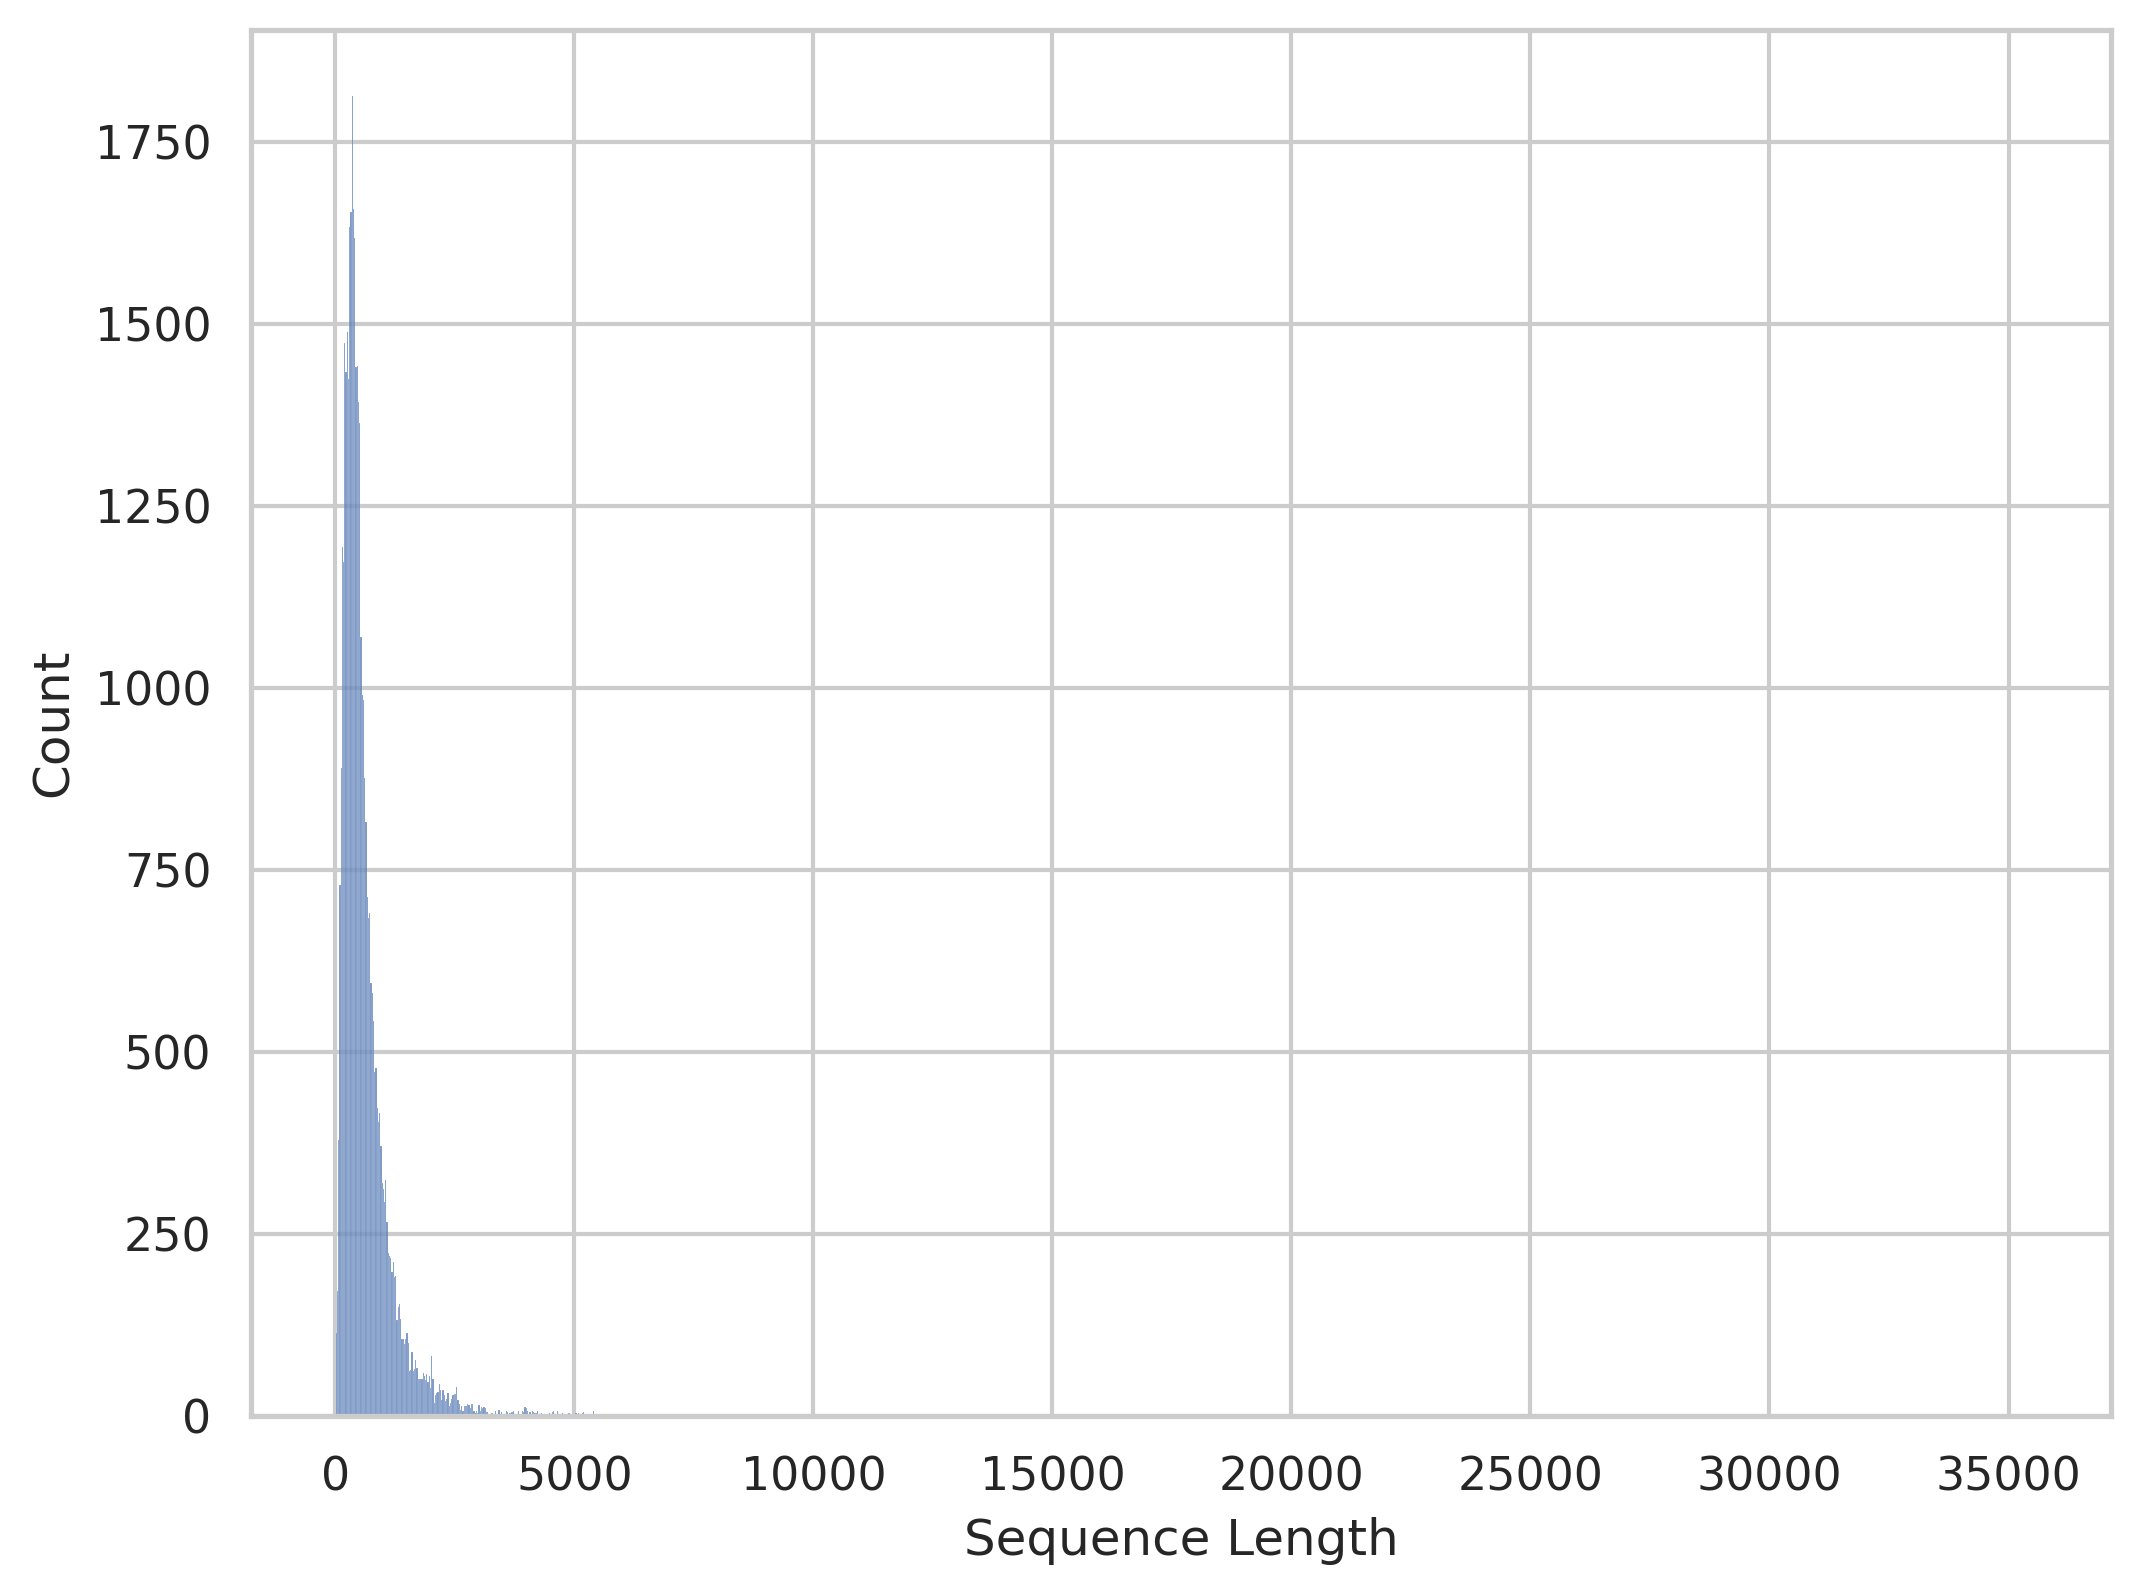

In [10]:
# protein length distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.histplot(data=seq_lens, ax=ax)
ax.set(xlabel="Sequence Length")

#### ✂️ Split Data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# further split a validation set
valid_size = 0.25  # 0.8*0.25=0.2
train_df, valid_df = train_test_split(df, test_size=valid_size, random_state=0)

#### 🏭 Data Processing

In [13]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, EsmModel

In [14]:
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
seq = df["Sequence"].iloc[0]
len(seq)

328

In [16]:
seq

'MEWDNGTGQALGLPPTTCVYRENFKQLLLPPVYSAVLAAGLPLNICVITQICTSRRALTRTAVYTLNLALADLLYACSLPLLIYNYAQGDHWPFGDFACRLVRFLFYANLHGSILFLTCISFQRYLGICHPLAPWHKRGGRRAAWLVCVAVWLAVTTQCLPTAIFAATGIQRNRTVCYDLSPPALATHYMPYGMALTVIGFLLPFAALLACYCLLACRLCRQDGPAEPVAQERRGKAARMAVVVAAAFAISFLPFHITKTAYLAVRSTPGVPCTVLEAFAAAYKGTRPFASANSVLDPILFYFTQKKFRRRPHELLQKLTAKWQRQGR'

In [17]:
encoded_seq = tokenizer([seq], padding=False, truncation=True, return_tensors="np")
encoded_seq["input_ids"]

array([[ 0, 20,  9, 22, 13, 17,  6, 11,  6, 16,  5,  4,  6,  4, 14, 14,
        11, 11, 23,  7, 19, 10,  9, 17, 18, 15, 16,  4,  4,  4, 14, 14,
         7, 19,  8,  5,  7,  4,  5,  5,  6,  4, 14,  4, 17, 12, 23,  7,
        12, 11, 16, 12, 23, 11,  8, 10, 10,  5,  4, 11, 10, 11,  5,  7,
        19, 11,  4, 17,  4,  5,  4,  5, 13,  4,  4, 19,  5, 23,  8,  4,
        14,  4,  4, 12, 19, 17, 19,  5, 16,  6, 13, 21, 22, 14, 18,  6,
        13, 18,  5, 23, 10,  4,  7, 10, 18,  4, 18, 19,  5, 17,  4, 21,
         6,  8, 12,  4, 18,  4, 11, 23, 12,  8, 18, 16, 10, 19,  4,  6,
        12, 23, 21, 14,  4,  5, 14, 22, 21, 15, 10,  6,  6, 10, 10,  5,
         5, 22,  4,  7, 23,  7,  5,  7, 22,  4,  5,  7, 11, 11, 16, 23,
         4, 14, 11,  5, 12, 18,  5,  5, 11,  6, 12, 16, 10, 17, 10, 11,
         7, 23, 19, 13,  4,  8, 14, 14,  5,  4,  5, 11, 21, 19, 20, 14,
        19,  6, 20,  5,  4, 11,  7, 12,  6, 18,  4,  4, 14, 18,  5,  5,
         4,  4,  5, 23, 19, 23,  4,  4,  5, 23, 10,  4, 23, 10, 

In [18]:
tokenizer.decode(encoded_seq["input_ids"][0])

'<cls> M E W D N G T G Q A L G L P P T T C V Y R E N F K Q L L L P P V Y S A V L A A G L P L N I C V I T Q I C T S R R A L T R T A V Y T L N L A L A D L L Y A C S L P L L I Y N Y A Q G D H W P F G D F A C R L V R F L F Y A N L H G S I L F L T C I S F Q R Y L G I C H P L A P W H K R G G R R A A W L V C V A V W L A V T T Q C L P T A I F A A T G I Q R N R T V C Y D L S P P A L A T H Y M P Y G M A L T V I G F L L P F A A L L A C Y C L L A C R L C R Q D G P A E P V A Q E R R G K A A R M A V V V A A A F A I S F L P F H I T K T A Y L A V R S T P G V P C T V L E A F A A A Y K G T R P F A S A N S V L D P I L F Y F T Q K K F R R R P H E L L Q K L T A K W Q R Q G R <eos>'

In [19]:
# targets
targets = np.load(data_path / "train_bp_top100_targets.npy")
targets.shape

(52593, 100)

In [20]:
def tokenize_seqs(batch, tokenizer, targets):
    encoded_seqs = tokenizer(
        batch["Sequence"].tolist(),
        padding="longest",
        truncation=True,
        max_length=min(1024, tokenizer.model_max_length),
        return_tensors="np",
    )
    return dict(
        input_ids=encoded_seqs["input_ids"],
        attention_mask=encoded_seqs["attention_mask"],
        targets=targets[batch["Index"].tolist()],
    )

In [21]:
tokenize_seqs(train_df.iloc[:10], tokenizer, targets)

{'input_ids': array([[ 0, 20,  4, ...,  1,  1,  1],
        [ 0, 20,  5, ...,  1,  1,  1],
        [ 0, 20,  8, ...,  1,  1,  1],
        ...,
        [ 0, 20,  8, ..., 14, 11,  2],
        [ 0, 20, 21, ...,  1,  1,  1],
        [ 0, 20,  9, ...,  1,  1,  1]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


#### ☁️ Distributed Processing

In [22]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = (
    True  # deterministic
)

In [23]:
ds = ray.data.read_parquet(data_path / "top100_train_split.parquet")
ds = ds.random_shuffle(seed=0)
ds.take(1)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-26 19:37:29,014	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-02-26 19:37:29,017	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=56 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (28).
2024-02-26 19:37:29,018	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 56, each read task output is split into 56 smaller blocks.
2024-02-26 19:37:29,018	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-02-26 19:37:29,019	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_loc

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(ReadParquet->SplitBlocks(56) pid=61818) /home/ytian/anaconda3/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
(ReadParquet->SplitBlocks(56) pid=61818)   return transform_pyarrow.concat(tables)


[{'Entry ID': 'Q8H103',
  'Sequence': 'MASLSGLYSSSPSLKPAKNHSFKALPAQSRDSFSFPHTSKPTNLPLTLSSARSVARDISHADSKKELLKDPDALWKRYLDWFYQQKELGLYLDISRVGFTDEFVAEMEPRFQAAFKAMEDLEKGSIANPDEGRMVGHYWLRNSKLAPKPTLKTLIENTLDSICAFSDDIISGKIKPPSSPEGRFTQILSVGIGGSALGPQFVAEALAPDNPPLKIRFIDNTDPAGIDHQIAQLGPELASTLVVVISKSGGTPETRNGLLEVQKAFREAGLNFAKQGVAITQENSLLDNTARIEGWLARFPMYDWVGGRTSIMSAVGLLPAALQGINVREMLTGAALMDEATRTTSIKNNPAALLAMCWYWASNGVGSKDMVVLPYKDSLLLFSRYLQQLVMESLGKEFDLDGNTVNQGLTVYGNKGSTDQHAYIQQLRDGVHNFFATFIEVLRDRPPGHDWELEPGVTCGDYLFGMLQGTRSALYANGRESISVTIQEVTPTSVGAIIALYERAVGLYASIVNINAYHQPGVEAGKKAAAEVLALQKRVLSVLNEATCKDPVEPLTLEEIADRCHAPEEIEMIYKIIAHMSANDRVLIAEGNCGSPRSIKVYLGECNVDDLYA',
  'Index': 37932,
  '__index_level_0__': 37932}]

In [24]:
test_size = 0.25
train_ds, val_ds = ds.train_test_split(test_size=test_size)

2024-02-26 19:37:29,776	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=56 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (28).
2024-02-26 19:37:29,776	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 56, each read task output is split into 56 smaller blocks.
2024-02-26 19:37:29,777	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-26 19:37:29,777	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:29,777	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current(

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
sample_ds = train_ds.map_batches(
    tokenize_seqs,
    fn_kwargs={
        "tokenizer": tokenizer,
        "targets": targets,
    },
    batch_format="pandas",
)
sample_ds.show(1)

2024-02-26 19:37:30,121	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)] -> LimitOperator[limit=1]
2024-02-26 19:37:30,122	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:30,123	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/42 [00:00<?, ?it/s]

{'input_ids': array([ 0, 20,  5, ...,  1,  1,  1]), 'attention_mask': array([1, 1, 1, ..., 0, 0, 0]), 'targets': array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


## 🏃Training

In [26]:
import os
import json
import random

In [27]:
def set_seeds(seed=0):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [28]:
DATASET_LOC = data_path / "top100_train_split.parquet"


def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=0)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [29]:
class CustomPreprocessor:
    """Custom preprocessor class."""

    def transform(self, ds):
        return ds.map_batches(
            tokenize_seqs,
            fn_kwargs={
                "tokenizer": tokenizer,
                "targets": targets,
            },
            batch_format="pandas",
        )

#### 🤖 Model

In [30]:
llm = EsmModel.from_pretrained(model_name)
embedding_dim = llm.config.hidden_size
embedding_dim

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


320

In [31]:
pad_token_id = llm.config.pad_token_id
pad_token_id

1

In [32]:
# sample
batch = tokenizer([seq[:10], seq[10:30]], return_tensors="pt", padding="longest")
outputs = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2559,  0.5052,  0.3099,  ...,  0.9968, -0.0071, -0.5732],
         [ 0.4716,  0.2070,  0.0532,  ...,  0.0985, -0.0850, -0.1230],
         [ 0.0916, -0.5060,  0.4029,  ..., -0.0189,  0.3669,  0.1066],
         ...,
         [ 0.3785,  0.0248,  0.4352,  ...,  0.1507, -0.1511, -0.2577],
         [ 0.2569, -0.3657,  0.2987,  ..., -0.0413,  0.0628, -0.1386],
         [ 0.1770, -0.4435,  0.3045,  ..., -0.0101,  0.1693, -0.0363]],

        [[ 0.1086,  0.3751,  0.3241,  ...,  0.9366,  0.0989, -0.4282],
         [ 0.2838, -0.0449,  0.1504,  ...,  0.3779,  0.0744, -0.0126],
         [ 0.0363, -0.4895,  0.4146,  ...,  0.0421,  0.3205,  0.0104],
         ...,
         [ 0.2076, -0.4269,  0.3307,  ...,  0.0976,  0.1143,  0.1410],
         [-0.0593, -0.2874,  0.3794,  ..., -0.1142,  0.2607,  0.0996],
         [ 0.0355, -0.1201,  0.3995,  ...,  0.3110, -0.2717, -0.1309]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [33]:
last_hidden_state, pool = outputs.last_hidden_state, outputs.pooler_output
last_hidden_state.shape, pool.shape

(torch.Size([2, 22, 320]), torch.Size([2, 320]))

In [34]:
# mean pooling of last_hidden_state

# first expand the mask
mask = batch["attention_mask"].unsqueeze(-1).expand(last_hidden_state.shape).float()

# sum unmasked token embeddings
sum_embeddings = torch.sum(last_hidden_state * mask, dim=1)

# number of unmasked tokens for each sequence
# set a min value to avoid divide by zero
num_tokens = torch.clamp(mask.sum(1), min=1e-9)

# divide
mean_embeddings = sum_embeddings / num_tokens
mean_embeddings.shape

torch.Size([2, 320])

In [35]:
class FinetunedESM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super().__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = nn.Dropout(dropout_p)
        self.pre_classifier = nn.Linear(embedding_dim, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def mean_pooling(self, token_embeddings, attention_mask):
        """Average the embedding of all amino acids in a sequence"""

        # expand the mask
        expanded_mask = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        )

        # sum unmasked token embeddings
        sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)

        # number of unmasked tokens for each sequence
        # set a min value to avoid divide by zero
        num_tokens = torch.clamp(expanded_mask.sum(1), min=1e-9)

        # divide
        mean_embeddings = sum_embeddings / num_tokens
        return mean_embeddings

    def forward(self, batch):
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]

        # per token representations from the last layer
        token_embeddings = self.llm(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state

        # average per token representations
        mean_embeddings = self.mean_pooling(token_embeddings, attention_mask)

        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/distilbert/modeling_distilbert.py
        mean_embeddings = self.pre_classifier(mean_embeddings)  # (bs, embedding_dim)
        mean_embeddings = nn.ReLU()(mean_embeddings)
        mean_embeddings = self.dropout(mean_embeddings)

        logits = self.classifier(mean_embeddings)  # (bs, num_classes)
        return logits

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        y = self(batch)
        return y.cpu().numpy()

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

        torch.save(self.state_dict(), Path(dp) / "model.pt")

    @classmethod
    def load(cls, esm_model, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)

        llm = EsmModel.from_pretrained(esm_model)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(
            torch.load(state_dict_fp, map_location=torch.device("cpu"))
        )
        return model

In [36]:
num_classes = 100

# model = FinetunedESM(
#     llm=llm, dropout_p=0.1, embedding_dim=embedding_dim, num_classes=num_classes
# )
# print(model.parameters)

In [37]:
from ray.train.torch import get_device

get_device()

device(type='cuda', index=0)

In [38]:
def collate_fn(batch):
    padded = tokenizer.pad(
        {"input_ids": batch["input_ids"], "attention_mask": batch["attention_mask"]},
        return_tensors="pt",
    )

    batch["input_ids"] = padded["input_ids"].to(device=get_device())
    batch["attention_mask"] = padded["attention_mask"].to(device=get_device())
    batch["targets"] = torch.as_tensor(
        batch["targets"], dtype=torch.float, device=get_device()
    )

    return batch

In [39]:
sample_batch = sample_ds.take_batch(batch_size=8)
sample_batch

2024-02-26 19:37:32,936	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)] -> LimitOperator[limit=8]
2024-02-26 19:37:32,936	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:32,937	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/42 [00:00<?, ?it/s]

{'input_ids': array([[ 0, 20,  5, ...,  1,  1,  1],
        [ 0, 20,  9, ...,  1,  1,  1],
        [ 0, 20, 10, ...,  1,  1,  1],
        ...,
        [ 0, 20,  5, ...,  1,  1,  1],
        [ 0, 20,  9, ...,  1,  1,  1],
        [ 0, 20,  4, ...,  1,  1,  1]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,


In [40]:
sample_batch = collate_fn(batch=sample_batch)
sample_batch

{'input_ids': tensor([[ 0, 20,  5,  ...,  1,  1,  1],
         [ 0, 20,  9,  ...,  1,  1,  1],
         [ 0, 20, 10,  ...,  1,  1,  1],
         ...,
         [ 0, 20,  5,  ...,  1,  1,  1],
         [ 0, 20,  9,  ...,  1,  1,  1],
         [ 0, 20,  4,  ...,  1,  1,  1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'targets': tensor([[1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 

In [41]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size=test_size)
num_train_samples = train_ds.count()
preprocessor = CustomPreprocessor()
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-26 19:37:34,074	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=56 for stage ReadParquet to satisfy parallelism at least twice the available number of CPUs (28).
2024-02-26 19:37:34,075	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 56, each read task output is split into 56 smaller blocks.
2024-02-26 19:37:34,075	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-26 19:37:34,075	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:34,076	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current(

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(ReadParquet->SplitBlocks(56) pid=61818) /home/ytian/anaconda3/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
(ReadParquet->SplitBlocks(56) pid=61818)   return transform_pyarrow.concat(tables)
2024-02-26 19:37:34,337	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)]
2024-02-26 19:37:34,338	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:34,338	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/42 [00:00<?, ?it/s]

2024-02-26 19:37:35,564	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(tokenize_seqs)]
2024-02-26 19:37:35,565	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-26 19:37:35,565	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/15 [00:00<?, ?it/s]

In [42]:
import lightning as L
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.functional.classification import multilabel_f1_score

In [43]:
L.seed_everything(0)

Seed set to 0


0

In [44]:
class ESMLightningModule(L.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, batch):
        return self.model(batch)

    def training_step(self, batch, batch_idx):
        logits = self(batch)
        loss = self.loss_fn(logits, batch["targets"])
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        logits = self(batch)
        loss = self.loss_fn(logits, batch["targets"])
        self.log("val_loss", loss, prog_bar=True)

        f1_score = multilabel_f1_score(
            logits, batch["targets"].type(torch.int), num_classes
        )
        self.log("val_f1_score", f1_score, prog_bar=True)

    def test_step(self, batch, batch_idx):
        logits = self(batch)

        f1_score = multilabel_f1_score(
            logits, batch["targets"].type(torch.int), num_classes
        )
        self.log("f1_score", f1_score, prog_bar=True)

    def configure_optimizers(self):
        if self.global_rank == 0:
            print(self.trainer.model)
        optimizer = torch.optim.Adam(
            self.trainer.model.parameters(), lr=self.learning_rate
        )
        return optimizer

In [45]:
import functools
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
from torch.distributed.fsdp import ShardingStrategy, BackwardPrefetch
from ray.train.lightning import RayFSDPStrategy
from transformers.models.esm.modeling_esm import EsmLayer

In [46]:
auto_wrap_policy = functools.partial(
    transformer_auto_wrap_policy, transformer_layer_cls={EsmLayer}
)

fsdp_strategy = RayFSDPStrategy(
    sharding_strategy=ShardingStrategy.FULL_SHARD,
    backward_prefetch=BackwardPrefetch.BACKWARD_PRE,
    forward_prefetch=True,
    auto_wrap_policy=auto_wrap_policy,
    limit_all_gathers=True,
    activation_checkpointing_policy={EsmLayer},
)

In [47]:
from ray.train import Checkpoint
from ray.train.lightning import (
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

In [48]:
def train_loop_per_worker(config):
    # Hyperparameters
    esm_model = config["esm_model"]
    dropout_p = config["dropout_p"]
    strategy = config["strategy"]
    lr = config["lr"]
    num_epochs = config["num_epochs"]
    batch_size_per_worker = config["batch_size_per_worker"]
    num_classes = config["num_classes"]

    train_ds = ray.train.get_dataset_shard("train")
    val_ds = ray.train.get_dataset_shard("val")
    train_loader = train_ds.iter_torch_batches(
        batch_size=batch_size_per_worker, collate_fn=collate_fn
    )
    val_loader = val_ds.iter_torch_batches(
        batch_size=batch_size_per_worker, collate_fn=collate_fn
    )

    print(
        f"Training steps per epoch: {np.ceil(num_train_samples/batch_size_per_worker)}"
    )

    llm = EsmModel.from_pretrained(esm_model)
    model = FinetunedESM(
        llm=llm,
        dropout_p=dropout_p,
        embedding_dim=llm.config.hidden_size,
        num_classes=num_classes,
    )
    lightning_model = ESMLightningModule(model, lr)

    trainer = pl.Trainer(
        max_epochs=num_epochs,
        devices=num_devices,
        accelerator="cuda",
        precision="16-mixed",
        strategy=strategy,
        plugins=[RayLightningEnvironment()],
        callbacks=[RayTrainReportCallback()],
        enable_checkpointing=True,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(
        lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader
    )

In [49]:
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

In [50]:
storage_path = str(Path().resolve() / "finetune_results")

In [51]:
run_config = RunConfig(
    name="finetune_esm_all_layers",
    storage_path=storage_path,
    checkpoint_config=CheckpointConfig(num_to_keep=1),
)

In [52]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=True,
    # resources_per_worker=resources_per_worker,
)

In [53]:
# Train loop config
train_loop_config = {
    "esm_model": model_name,
    "dropout_p": 0.1,
    "strategy": fsdp_strategy,
    "lr": 1e-3,
    "num_epochs": 1,
    "batch_size_per_worker": 4,
    "num_classes": num_classes,
}

In [54]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
)

In [55]:
%%time
# Train
results = trainer.fit()

(RayTrainWorker pid=65462) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=65462) [W Utils.hpp:133] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function getCvarInt)
(TorchTrainer pid=65386) Started distributed worker processes: 
(TorchTrainer pid=65386) - (ip=172.30.66.101, pid=65462) world_rank=0, local_rank=0, node_rank=0


(RayTrainWorker pid=65462) Training steps per epoch: 7889.0


(SplitCoordinator pid=65530) Auto configuring locality_with_output=['505b388a8547130789bff374dc746e35c6d67c8af71a6d7d5b2d2b4f']
(RayTrainWorker pid=65462) Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
(RayTrainWorker pid=65462) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(RayTrainWorker pid=65462) GPU available: True (cuda), used: True
(RayTrainWorker pid=65462) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=65462) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=65462) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=65462) You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more detail

(RayTrainWorker pid=65462) FullyShardedDataParallel(
(RayTrainWorker pid=65462)   (_fsdp_wrapped_module): ESMLightningModule(
(RayTrainWorker pid=65462)     (model): FinetunedESM(
(RayTrainWorker pid=65462)       (llm): EsmModel(
(RayTrainWorker pid=65462)         (embeddings): EsmEmbeddings(
(RayTrainWorker pid=65462)           (word_embeddings): Embedding(33, 320, padding_idx=1)
(RayTrainWorker pid=65462)           (dropout): Dropout(p=0.0, inplace=False)
(RayTrainWorker pid=65462)           (position_embeddings): Embedding(1026, 320, padding_idx=1)
(RayTrainWorker pid=65462)         )
(RayTrainWorker pid=65462)         (encoder): EsmEncoder(
(RayTrainWorker pid=65462)           (layer): ModuleList(
(RayTrainWorker pid=65462)             (0-5): 6 x FullyShardedDataParallel(
(RayTrainWorker pid=65462)               (_fsdp_wrapped_module): CheckpointWrapper(
(RayTrainWorker pid=65462)                 (_checkpoint_wrapped_module): EsmLayer(
(RayTrainWorker pid=65462)                   (

(RayTrainWorker pid=65462) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(RayTrainWorker pid=65462) 
(RayTrainWorker pid=65462)   | Name    | Type              | Params
(RayTrainWorker pid=65462) ----------------------------------------------
(RayTrainWorker pid=65462) 0 | model   | FinetunedESM      | 8.0 M 
(RayTrainWorker pid=65462) 1 | loss_fn | BCEWithLogitsLoss | 0     
(RayTrainWorker pid=65462) ----------------------------------------------
(RayTrainWorker pid=65462) 8.0 M     Trainable params
(RayTrainWorker pid=65462) 0         Non-trainable params
(RayTrainWorker pid=65462) 8.0 M     Total params
(RayTrainWorker pid=65462) 31.900    Total estimated model params size (MB)


(pid=65530) Running 0:   0%|          | 0/15 [00:00<?, ?it/s]

(SplitCoordinator pid=65530) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=65530) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=1.0, gpu=1.0, object_store_memory=0.0), locality_with_output=['505b388a8547130789bff374dc746e35c6d67c8af71a6d7d5b2d2b4f'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=65530) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=65462) /home/ytian/anaconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=65462) /home/ytian/anaco

                                                                           
Epoch 0: |          | 0/? [00:00<?, ?it/s] 


(pid=65529) Running 0:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0: |          | 1/? [00:00<00:00,  6.46it/s, v_num=0]
Epoch 0: |          | 2/? [00:00<00:00,  8.34it/s, v_num=0]
Epoch 0: |          | 3/? [00:00<00:00,  9.22it/s, v_num=0]
Epoch 0: |          | 4/? [00:00<00:00,  9.75it/s, v_num=0]
Epoch 0: |          | 6/? [00:00<00:00, 10.36it/s, v_num=0]
Epoch 0: |          | 7/? [00:00<00:00, 10.53it/s, v_num=0]
Epoch 0: |          | 8/? [00:00<00:00, 10.67it/s, v_num=0]
Epoch 0: |          | 9/? [00:00<00:00, 10.78it/s, v_num=0]
Epoch 0: |          | 10/? [00:00<00:00, 10.87it/s, v_num=0]
Epoch 0: |          | 11/? [00:01<00:00, 10.94it/s, v_num=0]
Epoch 0: |          | 13/? [00:01<00:00, 11.06it/s, v_num=0]
Epoch 0: |          | 14/? [00:01<00:00, 11.10it/s, v_num=0]
Epoch 0: |          | 15/? [00:01<00:00, 11.13it/s, v_num=0]
Epoch 0: |          | 16/? [00:01<00:00, 11.17it/s, v_num=0]
Epoch 0: |          | 17/? [00:01<00:00, 11.20it/s, v_num=0]
Epoch 0: |          | 19/? [00:01<00:00, 11.25it/s, v_num=0]
Epoch 0: |          | 20/? [00:0

(pid=65530) Running 0:   0%|          | 0/15 [00:00<?, ?it/s]

(RayTrainWorker pid=65462) 
Validation DataLoader 0: |          | 2/? [00:00<00:00, 37.80it/s]
Validation DataLoader 0: |          | 3/? [00:00<00:00, 38.08it/s]
Validation DataLoader 0: |          | 4/? [00:00<00:00, 38.48it/s]
Validation DataLoader 0: |          | 5/? [00:00<00:00, 38.95it/s]


(SplitCoordinator pid=65529) Auto configuring locality_with_output=['505b388a8547130789bff374dc746e35c6d67c8af71a6d7d5b2d2b4f']
(SplitCoordinator pid=65530) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)] [repeated 2x across cluster]
(SplitCoordinator pid=65530) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=1.0, gpu=1.0, object_store_memory=0.0), locality_with_output=['505b388a8547130789bff374dc746e35c6d67c8af71a6d7d5b2d2b4f'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False) [repeated 2x across cluster]
(SplitCoordinator pid=65530) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True` [repeated 2x across cluster]


(RayTrainWorker pid=65462) 
Validation DataLoader 0: |          | 6/? [00:00<00:00, 39.06it/s]
Validation DataLoader 0: |          | 7/? [00:00<00:00, 39.22it/s]
Validation DataLoader 0: |          | 8/? [00:00<00:00, 39.43it/s]
Validation DataLoader 0: |          | 9/? [00:00<00:00, 39.56it/s]
(RayTrainWorker pid=65462) 
Validation DataLoader 0: |          | 10/? [00:00<00:00, 38.95it/s]
Validation DataLoader 0: |          | 11/? [00:00<00:00, 39.11it/s]
Validation DataLoader 0: |          | 12/? [00:00<00:00, 39.26it/s]
Validation DataLoader 0: |          | 13/? [00:00<00:00, 39.26it/s]
(RayTrainWorker pid=65462) 
Validation DataLoader 0: |          | 14/? [00:00<00:00, 39.30it/s]
Validation DataLoader 0: |          | 15/? [00:00<00:00, 39.39it/s]
Validation DataLoader 0: |          | 16/? [00:00<00:00, 39.44it/s]
Validation DataLoader 0: |          | 17/? [00:00<00:00, 39.51it/s]
(RayTrainWorker pid=65462) 
Validation DataLoader 0: |          | 18/? [00:00<00:00, 39.57it/s]
Validati

(RayTrainWorker pid=65462) [rank0]:[2024-02-26 19:49:50,956] torch.distributed.fsdp._debug_utils: [WARNING] FSDP _optim_state_dict() profiling:  defaultdict(<class 'float'>, {'preprocessing': 0.0018438860006426694, 'preprocessing_with_comm': 0.0011752539994631661, 'state_converting': 4.3246000132057816e-05, <Type.ALL: 'all'>: 0.003358511999977054})
(RayTrainWorker pid=65462) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-finetune/notebooks/finetune_results/finetune_esm_all_layers/TorchTrainer_8cc56_00000_0_2024-02-26_19-37-36/checkpoint_000000)
(RayTrainWorker pid=65462) [rank0]:[2024-02-26 19:49:51,098] torch.distributed.fsdp._debug_utils: [WARNING] FSDP _optim_state_dict() profiling:  defaultdict(<class 'float'>, {'preprocessing': 0.003363571000591037, 'preprocessing_with_comm': 0.001323123999100062, 'state_converting': 5.10300014866516e-05, <Type.ALL: 'all'>: 0.005103124000015669})


Epoch 0: |          | 7889/? [12:09<00:00, 10.81it/s, v_num=0, val_loss=0.463, val_f1_score=0.057]


(RayTrainWorker pid=65462) `Trainer.fit` stopped: `max_epochs=1` reached.
2024-02-26 19:49:52,370	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2024-02-26 19:49:52,373	INFO tune.py:1042 -- Total run time: 735.63 seconds (735.54 seconds for the tuning loop).


CPU times: user 9.11 s, sys: 2.06 s, total: 11.2 s
Wall time: 12min 15s


In [56]:
results.metrics_dataframe

,train_loss,val_loss,val_f1_score,epoch,step,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/esm_model,config/train_loop_config/dropout_p,config/train_loop_config/strategy,config/train_loop_config/lr,config/train_loop_config/num_epochs,config/train_loop_config/batch_size_per_worker,config/train_loop_config/num_classes
0,0.472829,0.463153,0.057027,0,7889,1709005791,checkpoint_000000,True,False,1,...,172.30.66.101,732.330594,1,facebook/esm2_t6_8M_UR50D,0.1,<ray.train.lightning._lightning_utils.RayFSDPS...,0.001,1,4,100


In [57]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/home/ytian/github/esm-finetune/notebooks/finetune_results/finetune_esm_all_layers/TorchTrainer_8cc56_00000_0_2024-02-26_19-37-36/checkpoint_000000),
  {'train_loss': 0.4728288948535919,
   'val_loss': 0.46315255761146545,
   'val_f1_score': 0.05702654644846916,
   'epoch': 0,
   'step': 7889,
   'timestamp': 1709005791,
   'checkpoint_dir_name': 'checkpoint_000000',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 1,
   'trial_id': '8cc56_00000',
   'date': '2024-02-26_19-49-51',
   'time_this_iter_s': 732.3305940628052,
   'time_total_s': 732.3305940628052,
   'pid': 65386,
   'hostname': 'Witcher',
   'node_ip': '172.30.66.101',
   'config': {'train_loop_config': {'esm_model': 'facebook/esm2_t6_8M_UR50D',
     'dropout_p': 0.1,
     'strategy': <ray.train.lightning._lightning_utils.RayFSDPStrategy at 0x7fb147831150>,
     'lr': 0.001,
     'num_epochs': 1,
     'batch_size_per_worker': 4,
     'num_classes': 100}},
   'time